In [1]:
# Getting cleaned dataset from df_final.parquet
import pandas as pd
df = pd.read_parquet('df_final.parquet')

In [2]:
# Splitting into dependent(Y) and independent(X)
X = df.drop('is_alive', axis=1)
y = df['is_alive']

In [3]:
# train-valid-test split
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 540969
Validation set size: 67546
Test set size: 67613


In [4]:
# Obtaining feature engineered X from parquet
X_train_common = pd.read_parquet('X_train_common.parquet')
X_val_common = pd.read_parquet('X_val_common.parquet')
X_test_common = pd.read_parquet('X_test_common.parquet')

## Decision Tree

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

models_to_test = {
    'DecisionTree_depth_5': DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10, random_state=42),
    'DecisionTree_depth_10': DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10, random_state=42)
}

validation_results = {}

for name, model in models_to_test.items():
    # Train the model on the training data
    model.fit(X_train_common, y_train)
    
    # Make predictions on the validation set
    y_pred_val = model.predict(X_val_common)
    
    # Calculate accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    validation_results[name] = val_accuracy
    
    print(f"Validation accuracy for {name}: {val_accuracy:.4f}")

best_model_name = max(validation_results, key=validation_results.get)
best_model = models_to_test[best_model_name]
print(f"\nBest model based on validation accuracy: {best_model_name}")

Validation accuracy for DecisionTree_depth_5: 0.8463
Validation accuracy for DecisionTree_depth_10: 0.8985

Best model based on validation accuracy: DecisionTree_depth_10


In [6]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train_common, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.89658391 0.89734181 0.8987467  0.89843245 0.89673084]
Mean CV accuracy: 0.8976


In [7]:
from sklearn.metrics import classification_report

y_pred_test = best_model.predict(X_test_common)
final_test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Final test accuracy for the best model: {final_test_accuracy:.4f}")
print(classification_report(y_test, y_pred_test))

Final test accuracy for the best model: 0.8957
              precision    recall  f1-score   support

           0       0.92      0.85      0.88     30952
           1       0.88      0.94      0.91     36661

    accuracy                           0.90     67613
   macro avg       0.90      0.89      0.89     67613
weighted avg       0.90      0.90      0.90     67613



## AdaBoost Classifier

In [8]:
from sklearn.ensemble import AdaBoostClassifier
base_estimator = DecisionTreeClassifier(max_depth=1)

models_to_test = {
    'adaboost_1': AdaBoostClassifier(
                                estimator=base_estimator,
                                n_estimators=50,
                                learning_rate=1.0,
                                random_state=42
                            ),
    'adaboost_2': AdaBoostClassifier(
                                estimator=base_estimator,
                                n_estimators=75,
                                learning_rate=2.0,
                                random_state=42
                            ),
    'adaboost_3': AdaBoostClassifier(
                                estimator=base_estimator,
                                n_estimators=100,
                                learning_rate=0.5,
                                random_state=42
                            )
}
validation_results = {}
for name, model in models_to_test.items():
    # Train the model on the training data
    model.fit(X_train_common, y_train)
    
    # Make predictions on the validation set
    y_pred_val = model.predict(X_val_common)
    
    # Calculate accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    validation_results[name] = val_accuracy
    
    print(f"Validation accuracy for {name}: {val_accuracy:.4f}")
best_model_name = max(validation_results, key=validation_results.get)
best_model = models_to_test[best_model_name]

print(f"\nBest model based on validation accuracy: {best_model_name}")

Validation accuracy for adaboost_1: 0.8802
Validation accuracy for adaboost_2: 0.7757
Validation accuracy for adaboost_3: 0.8780

Best model based on validation accuracy: adaboost_1


In [9]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train_common, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.87869013 0.87774738 0.87814481 0.87679539 0.87731184]
Mean CV accuracy: 0.8777


In [10]:
y_pred_test = best_model.predict(X_test_common)
final_test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Final test accuracy for the best model: {final_test_accuracy:.4f}")
print(classification_report(y_test, y_pred_test))

Final test accuracy for the best model: 0.8787
              precision    recall  f1-score   support

           0       0.88      0.85      0.87     30952
           1       0.88      0.90      0.89     36661

    accuracy                           0.88     67613
   macro avg       0.88      0.88      0.88     67613
weighted avg       0.88      0.88      0.88     67613



## Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

models_to_test = {
    'rf_depth_5': RandomForestClassifier(
                    n_estimators=100,
                    max_depth=5,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    random_state=42
                ),
    'rf_depth_10': RandomForestClassifier(
                    n_estimators=100,
                    max_depth=10,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    random_state=42
                ),
    'rf_more_estimators': RandomForestClassifier(
                    n_estimators=200,
                    max_depth=8,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    random_state=42
                )
}
validation_results = {}
for name, model in models_to_test.items():
    # Train the model on the training data
    model.fit(X_train_common, y_train)
    
    # Make predictions on the validation set
    y_pred_val = model.predict(X_val_common)
    
    # Calculate accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    validation_results[name] = val_accuracy
    
    print(f"Validation accuracy for {name}: {val_accuracy:.4f}")

best_model_name = max(validation_results, key=validation_results.get)
best_model = models_to_test[best_model_name]

print(f"\nBest model based on validation accuracy: {best_model_name}")

Validation accuracy for rf_depth_5: 0.8581
Validation accuracy for rf_depth_10: 0.8942
Validation accuracy for rf_more_estimators: 0.8770

Best model based on validation accuracy: rf_depth_10


In [12]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train_common, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.89497569 0.89082574 0.89240623 0.89157439 0.89218341]
Mean CV accuracy: 0.8924


In [13]:
y_pred_test = best_model.predict(X_test_common)
final_test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Final test accuracy for the best model: {final_test_accuracy:.4f}")
print(classification_report(y_test, y_pred_test))

Final test accuracy for the best model: 0.8927
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     30952
           1       0.89      0.92      0.90     36661

    accuracy                           0.89     67613
   macro avg       0.89      0.89      0.89     67613
weighted avg       0.89      0.89      0.89     67613



## K Nearest Neighbour

In [14]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

models_to_test = {
    'knn_2_neighbours': KNeighborsClassifier(
                            n_neighbors=2,
                            weights='distance',
                            metric='euclidean'
                        ),
    'knn_3_neighbours': KNeighborsClassifier(
                            n_neighbors=3,
                            weights='distance',
                            metric='euclidean'
                        ),
    'knn_5_neighbours': KNeighborsClassifier(
                            n_neighbors=4,
                            weights='distance',
                            metric='euclidean'
                        )
}
validation_results = {}
for name, model in models_to_test.items():
    # Train the model on the training data
    model.fit(X_train_common, y_train)
    
    # Make predictions on the validation set
    y_pred_val = model.predict(X_val_common)
    
    # Calculate accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    validation_results[name] = val_accuracy
    
    print(f"Validation accuracy for {name}: {val_accuracy:.4f}")

best_model_name = max(validation_results, key=validation_results.get)
best_model = models_to_test[best_model_name]

print(f"\nBest model based on validation accuracy: {best_model_name}")

Validation accuracy for knn_2_neighbours: 0.9275
Validation accuracy for knn_3_neighbours: 0.9382
Validation accuracy for knn_5_neighbours: 0.9386

Best model based on validation accuracy: knn_5_neighbours


In [15]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train_common, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.93769525 0.93872119 0.93869346 0.93779692 0.93667797]
Mean CV accuracy: 0.9379


In [16]:
y_pred_test = best_model.predict(X_test_common)
final_test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Final test accuracy for the best model: {final_test_accuracy:.4f}")
print(classification_report(y_test, y_pred_test))

Final test accuracy for the best model: 0.9385
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     30952
           1       0.94      0.95      0.94     36661

    accuracy                           0.94     67613
   macro avg       0.94      0.94      0.94     67613
weighted avg       0.94      0.94      0.94     67613



## Linear SVC

In [17]:
from sklearn.svm import LinearSVC

models_to_test = {
    'lsvc_c_0.1': LinearSVC(C=0.1, max_iter=10000, random_state=42),
    'lsvc_c_1.0': LinearSVC(C=1.0, max_iter=10000, random_state=42),
    'lsvc_c_10.0': LinearSVC(C=10.0, max_iter=10000, random_state=42)
}

validation_results = {}
for name, model in models_to_test.items():
    # Train the model on the training data
    model.fit(X_train_common, y_train)
    
    # Make predictions on the validation set
    y_pred_val = model.predict(X_val_common)
    
    # Calculate accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    validation_results[name] = val_accuracy
    
    print(f"Validation accuracy for {name}: {val_accuracy:.4f}")

best_model_name = max(validation_results, key=validation_results.get)
best_model = models_to_test[best_model_name]

print(f"\nBest model based on validation accuracy: {best_model_name}")

Validation accuracy for lsvc_c_0.1: 0.9354
Validation accuracy for lsvc_c_1.0: 0.9355
Validation accuracy for lsvc_c_10.0: 0.9355

Best model based on validation accuracy: lsvc_c_1.0


In [18]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train_common, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.93567111 0.93686341 0.93660462 0.93571732 0.93336907]
Mean CV accuracy: 0.9356


In [19]:
y_pred_test = best_model.predict(X_test_common)
final_test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Final test accuracy for the best model: {final_test_accuracy:.4f}")
print(classification_report(y_test, y_pred_test))

Final test accuracy for the best model: 0.9342
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     30952
           1       0.91      0.97      0.94     36661

    accuracy                           0.93     67613
   macro avg       0.94      0.93      0.93     67613
weighted avg       0.94      0.93      0.93     67613



## Gaussian Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

models_to_test = {
    'gnb_smoothing_1e-9': GaussianNB(var_smoothing=1e-9),
    'gnb_smoothing_1e-8': GaussianNB(var_smoothing=1e-8),
    'gnb_smoothing_1e-7': GaussianNB(var_smoothing=1e-7)
}

validation_results = {}
for name, model in models_to_test.items():
    # Train the model on the training data
    model.fit(X_train_common, y_train)
    
    # Make predictions on the validation set
    y_pred_val = model.predict(X_val_common)
    
    # Calculate accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    validation_results[name] = val_accuracy
    
    print(f"Validation accuracy for {name}: {val_accuracy:.4f}")

best_model_name = max(validation_results, key=validation_results.get)
best_model = models_to_test[best_model_name]

print(f"\nBest model based on validation accuracy: {best_model_name}")

Validation accuracy for gnb_smoothing_1e-9: 0.8272
Validation accuracy for gnb_smoothing_1e-8: 0.8272
Validation accuracy for gnb_smoothing_1e-7: 0.8272

Best model based on validation accuracy: gnb_smoothing_1e-9


In [21]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train_common, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.82913101 0.82671867 0.82660776 0.82910328 0.82562643]
Mean CV accuracy: 0.8274


In [22]:
y_pred_test = best_model.predict(X_test_common)
final_test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Final test accuracy for the best model: {final_test_accuracy:.4f}")
print(classification_report(y_test, y_pred_test))

Final test accuracy for the best model: 0.8269
              precision    recall  f1-score   support

           0       0.86      0.75      0.80     30952
           1       0.81      0.89      0.85     36661

    accuracy                           0.83     67613
   macro avg       0.83      0.82      0.82     67613
weighted avg       0.83      0.83      0.83     67613



## XGBoost Classifier

In [23]:
import xgboost as xgb

models_to_test = {
    'xgboost_1': xgb.XGBClassifier(
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=3,
                    eval_metric='logloss',
                    random_state=42
                ),
    'xgboost_2': xgb.XGBClassifier(
                    n_estimators=50,
                    learning_rate=0.1,
                    max_depth=5,
                    eval_metric='logloss',
                    random_state=42
                ),
    'xgboost_3': xgb.XGBClassifier(
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=3,
                    eval_metric='logloss',
                    random_state=42
                )
}

validation_results = {}
for name, model in models_to_test.items():
    # Train the model on the training data
    model.fit(X_train_common, y_train)
    
    # Make predictions on the validation set
    y_pred_val = model.predict(X_val_common)
    
    # Calculate accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    validation_results[name] = val_accuracy
    
    print(f"Validation accuracy for {name}: {val_accuracy:.4f}")

best_model_name = max(validation_results, key=validation_results.get)
best_model = models_to_test[best_model_name]

print(f"\nBest model based on validation accuracy: {best_model_name}")

Validation accuracy for xgboost_1: 0.9075
Validation accuracy for xgboost_2: 0.9153
Validation accuracy for xgboost_3: 0.9256

Best model based on validation accuracy: xgboost_3


In [24]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train_common, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.9269368  0.92688134 0.92754681 0.92731575 0.92508757]
Mean CV accuracy: 0.9268


In [25]:
y_pred_test = best_model.predict(X_test_common)
final_test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Final test accuracy for the best model: {final_test_accuracy:.4f}")
print(classification_report(y_test, y_pred_test))

Final test accuracy for the best model: 0.9262
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     30952
           1       0.91      0.96      0.93     36661

    accuracy                           0.93     67613
   macro avg       0.93      0.92      0.93     67613
weighted avg       0.93      0.93      0.93     67613



## Gradient Boosting

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

models_to_test = {
    'gradient_boost_1': GradientBoostingClassifier(
                            n_estimators=100,
                            learning_rate=0.1,
                            max_depth=3,
                            random_state=42
                        ),
    'gradient_boost_2': GradientBoostingClassifier(
                            n_estimators=50,
                            learning_rate=0.1,
                            max_depth=5,
                            random_state=42
                        ),
    'gradient_boost_3': GradientBoostingClassifier(
                            n_estimators=200,
                            learning_rate=0.1,
                            max_depth=3,
                            random_state=42
                        )
}

validation_results = {}
for name, model in models_to_test.items():
    # Train the model on the training data
    model.fit(X_train_common, y_train)
    
    # Make predictions on the validation set
    y_pred_val = model.predict(X_val_common)
    
    # Calculate accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_pred_val)
    
    validation_results[name] = val_accuracy
    
    print(f"Validation accuracy for {name}: {val_accuracy:.4f}")

best_model_name = max(validation_results, key=validation_results.get)
best_model = models_to_test[best_model_name]

print(f"\nBest model based on validation accuracy: {best_model_name}")

Validation accuracy for gradient_boost_1: 0.9092
Validation accuracy for gradient_boost_2: 0.9182
Validation accuracy for gradient_boost_3: 0.9264

Best model based on validation accuracy: gradient_boost_3


In [27]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train_common, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.9256151  0.92523615 0.92732499 0.92649315 0.92480105]
Mean CV accuracy: 0.9259


In [28]:
y_pred_test = best_model.predict(X_test_common)
final_test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Final test accuracy for the best model: {final_test_accuracy:.4f}")
print(classification_report(y_test, y_pred_test))

Final test accuracy for the best model: 0.9260
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     30952
           1       0.91      0.96      0.93     36661

    accuracy                           0.93     67613
   macro avg       0.93      0.92      0.93     67613
weighted avg       0.93      0.93      0.93     67613



## Ensemble 1

In [29]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('rf', RandomForestClassifier(
                    n_estimators=100,
                    max_depth=10,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    random_state=42
                )),
    ('linear-svc', LinearSVC(C=1.0, max_iter=10000, random_state=42)),
    ('boost', GradientBoostingClassifier(
                            n_estimators=200,
                            learning_rate=0.1,
                            max_depth=5,
                            random_state=42
                        ))
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train_common, y_train)

,estimators,"[('rf', ...), ('linear-svc', ...), ...]"
,final_estimator,LogisticRegression()
,cv,None
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,5


In [30]:
y_pred_val = stacking_model.predict(X_val_common)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(val_accuracy)
print(classification_report(y_val, y_pred_val))

0.946673378142303
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     30996
           1       0.93      0.97      0.95     36550

    accuracy                           0.95     67546
   macro avg       0.95      0.94      0.95     67546
weighted avg       0.95      0.95      0.95     67546



In [31]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(stacking_model, X_train_common, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.9460691  0.94722443 0.9471967  0.94608758 0.94449733]
Mean CV accuracy: 0.9462


In [32]:
y_pred_test = stacking_model.predict(X_test_common)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(test_accuracy)
print(classification_report(y_test, y_pred_test))

0.9463416798544658
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     30952
           1       0.93      0.97      0.95     36661

    accuracy                           0.95     67613
   macro avg       0.95      0.94      0.95     67613
weighted avg       0.95      0.95      0.95     67613



## Ensemble 2

In [33]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=10, random_state=42),  # shallower tree
    n_estimators=5,                                 # fewer trees
    random_state=42
)

boosting = xgb.XGBClassifier(
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=7,
                    eval_metric='logloss',
                    random_state=42
                )

stack_inner = StackingClassifier(
    estimators = [
        ('linear-svc', LinearSVC(C=1.0, max_iter=10000, random_state=42)),
        ('knn', KNeighborsClassifier(
            n_neighbors=7,
            weights='distance',
            metric='euclidean'
        ),
        'logistic-reg', LogisticRegression(C=10, random_state=42, max_iter=1000))
    ],
    final_estimator=LogisticRegression(max_iter=100)
)

# Final ensemble stacking the reduced models
final_ensemble = StackingClassifier(
    estimators=[
        ('bag', bagging),
        ('boost', boosting),
        ('stack', stack_inner)
    ],
    final_estimator=LogisticRegression(max_iter=100)
)

# Fit on training data
final_ensemble.fit(X_train_common, y_train)

# Evaluate
from sklearn.metrics import accuracy_score
y_pred = final_ensemble.predict(X_test_common)
print(f"Final Ensemble Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Final Ensemble Accuracy: 0.9520


In [34]:
y_pred_val = final_ensemble.predict(X_val_common)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(val_accuracy)
print(classification_report(y_val, y_pred_val))

0.9526692920380185
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     30996
           1       0.95      0.97      0.96     36550

    accuracy                           0.95     67546
   macro avg       0.95      0.95      0.95     67546
weighted avg       0.95      0.95      0.95     67546



In [35]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(final_ensemble, X_train_common, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.95179955 0.95256669 0.95282548 0.95194743 0.95117984]
Mean CV accuracy: 0.9521


In [36]:
y_pred_test = final_ensemble.predict(X_test_common)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(test_accuracy)
print(classification_report(y_test, y_pred_test))

0.9520062709833907
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     30952
           1       0.95      0.97      0.96     36661

    accuracy                           0.95     67613
   macro avg       0.95      0.95      0.95     67613
weighted avg       0.95      0.95      0.95     67613



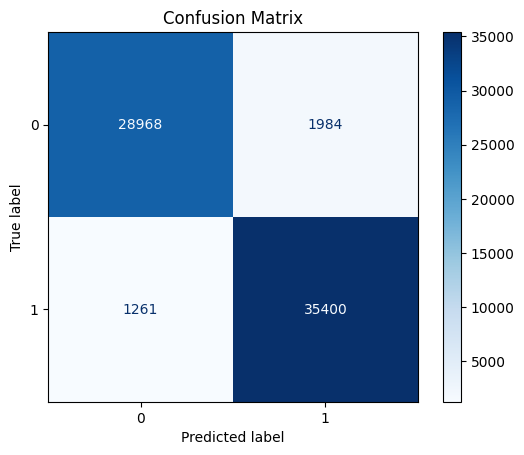

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plotting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Data from the table
data = {
    'Algorithm': [
        'Decision Tree Classifier',
        'AdaBoost Classifier', 
        'Random Forest Classifier',
        'Gaussian Naive Bayes',
        'XGBoost Classifier',
        'Gradient Boosting Classifier',
        'Proposed Model'
    ],
    'Precision': [0.9, 0.88, 0.89, 0.83, 0.93, 0.93, 0.95],
    'Recall': [0.9, 0.88, 0.89, 0.83, 0.93, 0.93, 0.95],
    'F1-score': [0.9, 0.88, 0.89, 0.83, 0.93, 0.93, 0.95],
    'Accuracy': [0.8957, 0.8787, 0.8927, 0.8269, 0.9252, 0.926, 0.952]
}

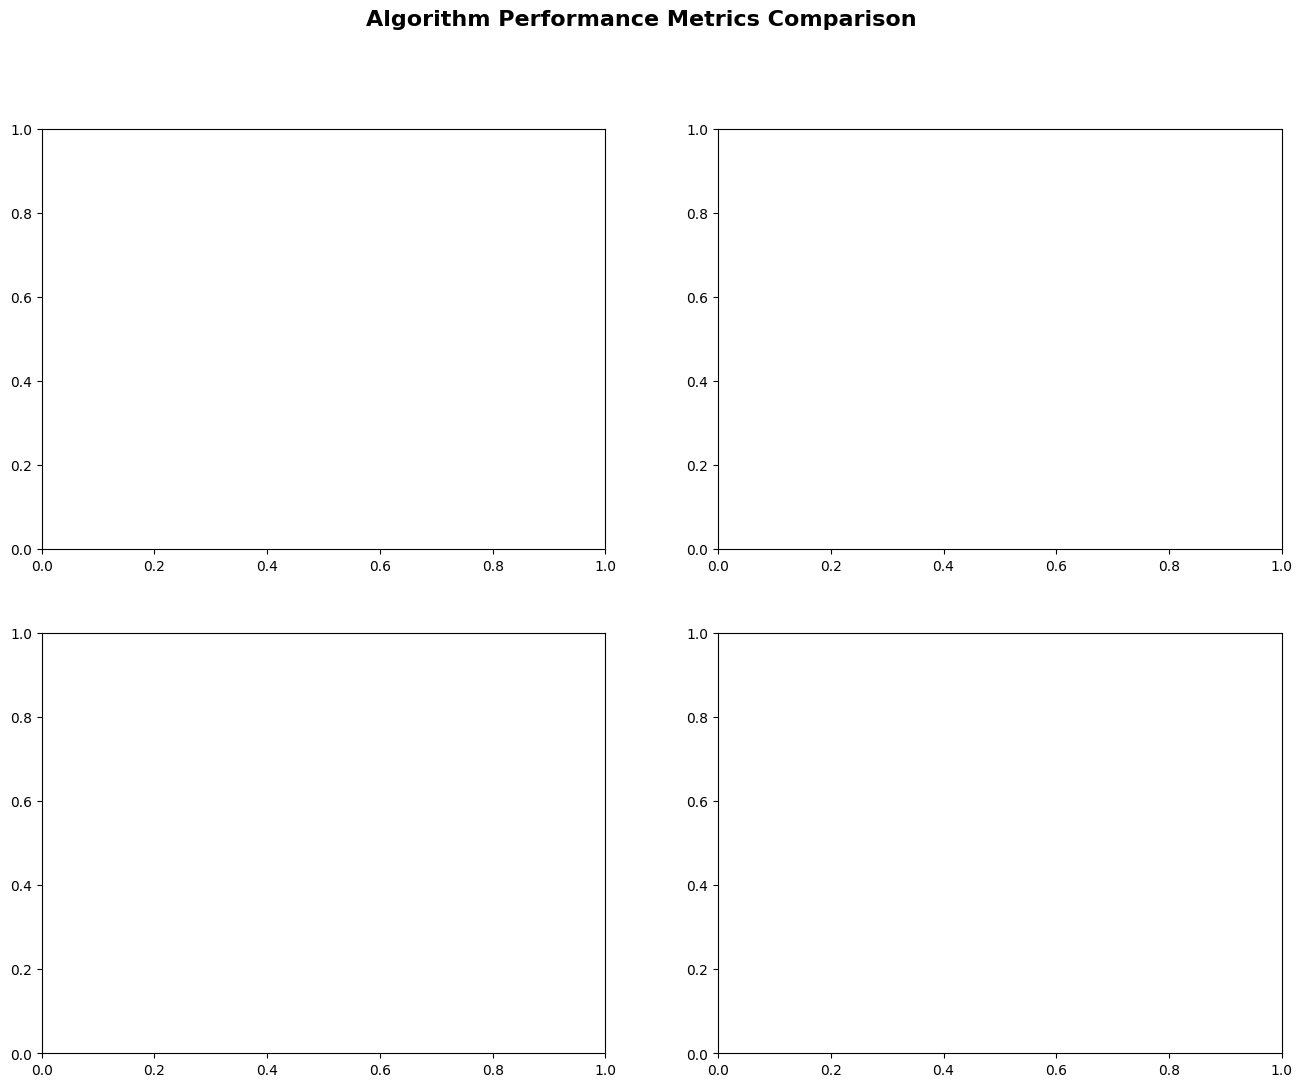

In [3]:
# Create DataFrame
df = pd.DataFrame(data)

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Algorithm Performance Metrics Comparison', fontsize=16, fontweight='bold')

# Colors for bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

<Figure size 640x480 with 0 Axes>

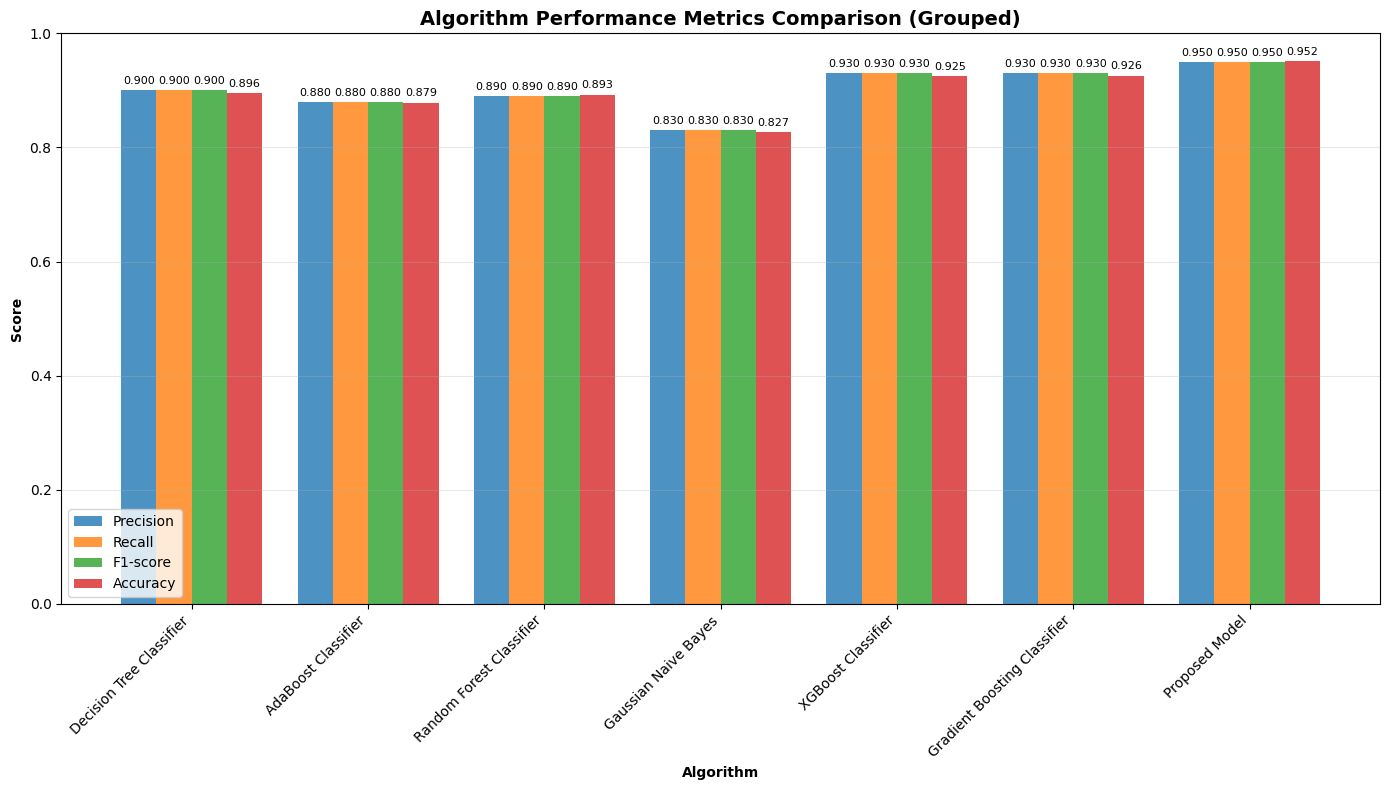


=== Summary Statistics ===
                      Algorithm  Precision  Recall  F1-score  Accuracy
0      Decision Tree Classifier       0.90    0.90      0.90    0.8957
1           AdaBoost Classifier       0.88    0.88      0.88    0.8787
2      Random Forest Classifier       0.89    0.89      0.89    0.8927
3          Gaussian Naive Bayes       0.83    0.83      0.83    0.8269
4            XGBoost Classifier       0.93    0.93      0.93    0.9252
5  Gradient Boosting Classifier       0.93    0.93      0.93    0.9260
6                Proposed Model       0.95    0.95      0.95    0.9520

Best performing algorithm overall: Proposed Model
Highest accuracy: Proposed Model (0.9520)


In [4]:
# Plot 1: Precision
axes[0, 0].bar(df['Algorithm'], df['Precision'], color=colors)
axes[0, 0].set_title('Precision', fontweight='bold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_ylim(0, 1.0)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Recall
axes[0, 1].bar(df['Algorithm'], df['Recall'], color=colors)
axes[0, 1].set_title('Recall', fontweight='bold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim(0, 1.0)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: F1-score
axes[1, 0].bar(df['Algorithm'], df['F1-score'], color=colors)
axes[1, 0].set_title('F1-score', fontweight='bold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_ylim(0, 1.0)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Accuracy
axes[1, 1].bar(df['Algorithm'], df['Accuracy'], color=colors)
axes[1, 1].set_title('Accuracy', fontweight='bold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1.0)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.93)

# Show the plot
plt.show()

# Alternative: Single plot with grouped bars
fig2, ax = plt.subplots(figsize=(14, 8))

# Set position of bars on X axis
x = np.arange(len(df['Algorithm']))
width = 0.2  # Width of bars

# Create bars
bars1 = ax.bar(x - 1.5*width, df['Precision'], width, label='Precision', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, df['Recall'], width, label='Recall', color='#ff7f0e', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, df['F1-score'], width, label='F1-score', color='#2ca02c', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, df['Accuracy'], width, label='Accuracy', color='#d62728', alpha=0.8)

# Add labels and title
ax.set_xlabel('Algorithm', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Algorithm Performance Metrics Comparison (Grouped)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df['Algorithm'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=8)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(df.round(4))
print(f"\nBest performing algorithm overall: {df['Algorithm'][df[['Precision', 'Recall', 'F1-score', 'Accuracy']].mean(axis=1).idxmax()]}")
print(f"Highest accuracy: {df['Algorithm'][df['Accuracy'].idxmax()]} ({df['Accuracy'].max():.4f})")

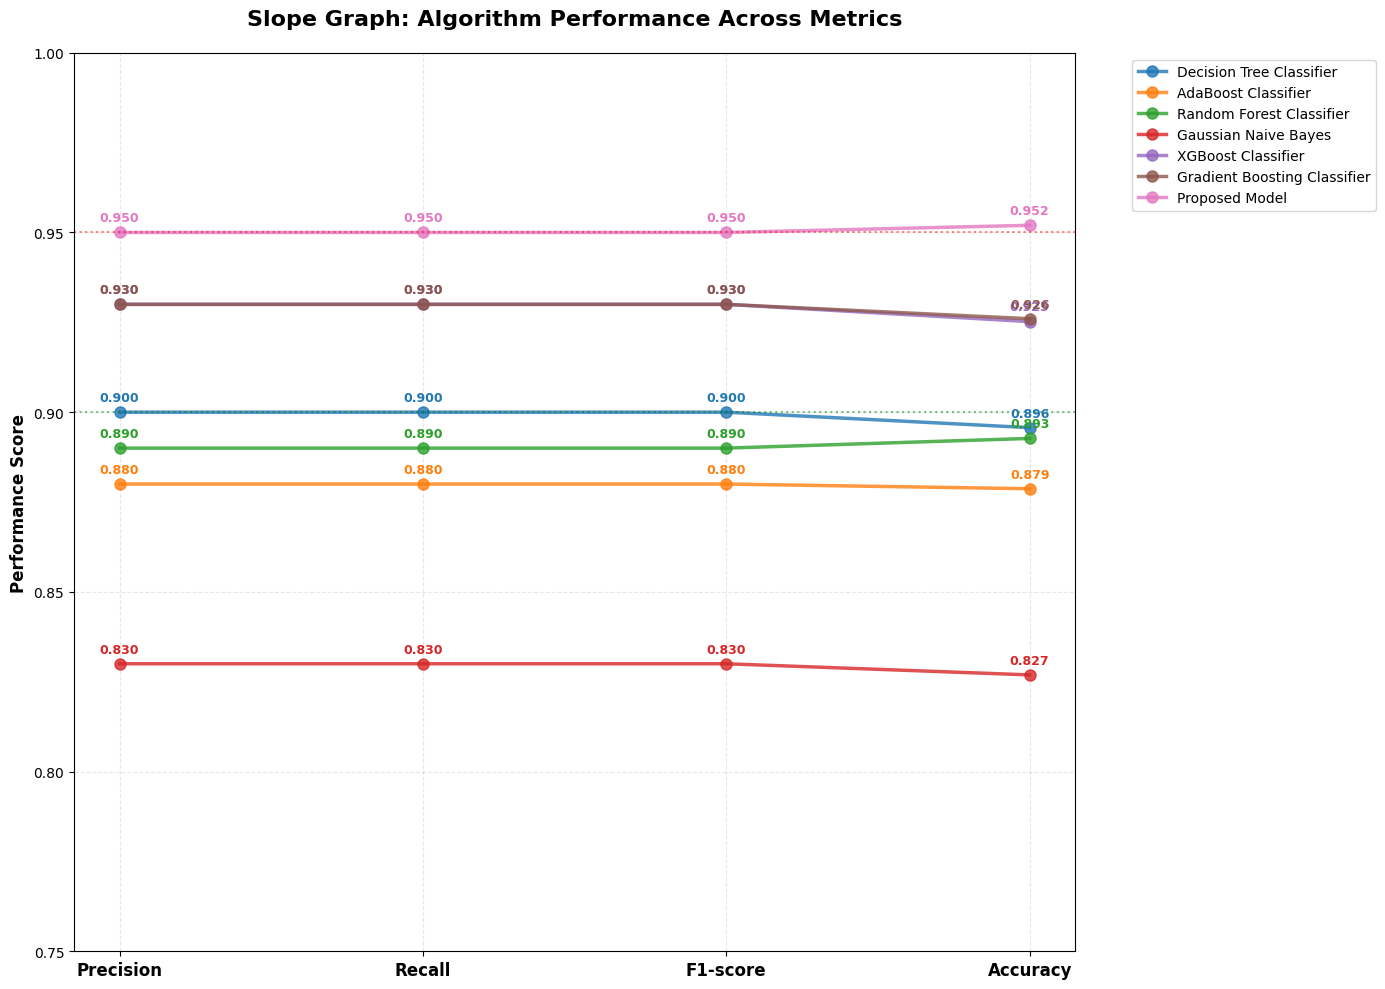


=== SLOPE GRAPH INSIGHTS ===
1. Performance Trends:
   Decision Tree Classifier: Decreasing trend, Variance: 0.0019
   AdaBoost Classifier: Decreasing trend, Variance: 0.0006
   Random Forest Classifier: Increasing trend, Variance: 0.0012
   Gaussian Naive Bayes: Decreasing trend, Variance: 0.0013
   XGBoost Classifier: Decreasing trend, Variance: 0.0021
   Gradient Boosting Classifier: Decreasing trend, Variance: 0.0017
   Proposed Model: Increasing trend, Variance: 0.0009

2. Most Consistent Algorithm: AdaBoost Classifier
3. Most Variable Algorithm: XGBoost Classifier
4. Best Overall Performance: Proposed Model


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data from the table
data = {
    'Algorithm': [
        'Decision Tree Classifier',
        'AdaBoost Classifier', 
        'Random Forest Classifier',
        'Gaussian Naive Bayes',
        'XGBoost Classifier',
        'Gradient Boosting Classifier',
        'Proposed Model'
    ],
    'Precision': [0.9, 0.88, 0.89, 0.83, 0.93, 0.93, 0.95],
    'Recall': [0.9, 0.88, 0.89, 0.83, 0.93, 0.93, 0.95],
    'F1-score': [0.9, 0.88, 0.89, 0.83, 0.93, 0.93, 0.95],
    'Accuracy': [0.8957, 0.8787, 0.8927, 0.8269, 0.9252, 0.926, 0.952]
}

# Create DataFrame
df = pd.DataFrame(data)

# Create the slope graph
plt.figure(figsize=(14, 10))

# Define metrics and their positions on x-axis
metrics = ['Precision', 'Recall', 'F1-score', 'Accuracy']
x_positions = [0, 1, 2, 3]

# Define colors for each algorithm
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Plot lines for each algorithm
for i, alg in enumerate(df['Algorithm']):
    values = [df.iloc[i]['Precision'], df.iloc[i]['Recall'], 
              df.iloc[i]['F1-score'], df.iloc[i]['Accuracy']]
    
    # Plot the line
    plt.plot(x_positions, values, 'o-', color=colors[i], linewidth=2.5, 
             markersize=8, label=alg, alpha=0.8)
    
    # Add value labels at each point
    for j, (x, y) in enumerate(zip(x_positions, values)):
        plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                    xytext=(0, 8), ha='center', fontsize=9, 
                    color=colors[i], fontweight='bold')

# Customize the plot
plt.xticks(x_positions, metrics, fontsize=12, fontweight='bold')
plt.ylabel('Performance Score', fontsize=12, fontweight='bold')
plt.title('Slope Graph: Algorithm Performance Across Metrics', 
          fontsize=16, fontweight='bold', pad=20)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Set y-axis limits to better show the data
plt.ylim(0.75, 1.0)

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Add horizontal reference lines for common thresholds
plt.axhline(y=0.9, color='green', linestyle=':', alpha=0.5, label='90% threshold')
plt.axhline(y=0.95, color='red', linestyle=':', alpha=0.5, label='95% threshold')

# Tight layout to prevent legend cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print summary insights
print("\n=== SLOPE GRAPH INSIGHTS ===")
print("1. Performance Trends:")
for i, alg in enumerate(df['Algorithm']):
    values = [df.iloc[i]['Precision'], df.iloc[i]['Recall'], 
              df.iloc[i]['F1-score'], df.iloc[i]['Accuracy']]
    trend = "Increasing" if values[-1] > values[0] else "Decreasing" if values[-1] < values[0] else "Stable"
    variance = np.std(values)
    print(f"   {alg}: {trend} trend, Variance: {variance:.4f}")

print(f"\n2. Most Consistent Algorithm: {df['Algorithm'][df[['Precision', 'Recall', 'F1-score', 'Accuracy']].std(axis=1).idxmin()]}")
print(f"3. Most Variable Algorithm: {df['Algorithm'][df[['Precision', 'Recall', 'F1-score', 'Accuracy']].std(axis=1).idxmax()]}")
print(f"4. Best Overall Performance: {df['Algorithm'][df[['Precision', 'Recall', 'F1-score', 'Accuracy']].mean(axis=1).idxmax()]}")